<a href="https://colab.research.google.com/github/Diana-codes/CropSenseAI_model_training/blob/main/Summative_Intro_to_ml_Diana_Ruzindana_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CropSense AI: Crop Disease Detection in Rwanda

Objective: This notebook explores classification models for plant disease detection using classical ML and neural networks, applying optimization techniques to improve performance.

A Notebook detailing the following

* Project name





**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo



Step 1: Setup and Install Dependencies

In [18]:
!pip install tensorflow tensorflow-datasets seaborn joblib


Step 2: Imports & Global Setup

In [31]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from joblib import dump

# SECTION 1: Model Architecture

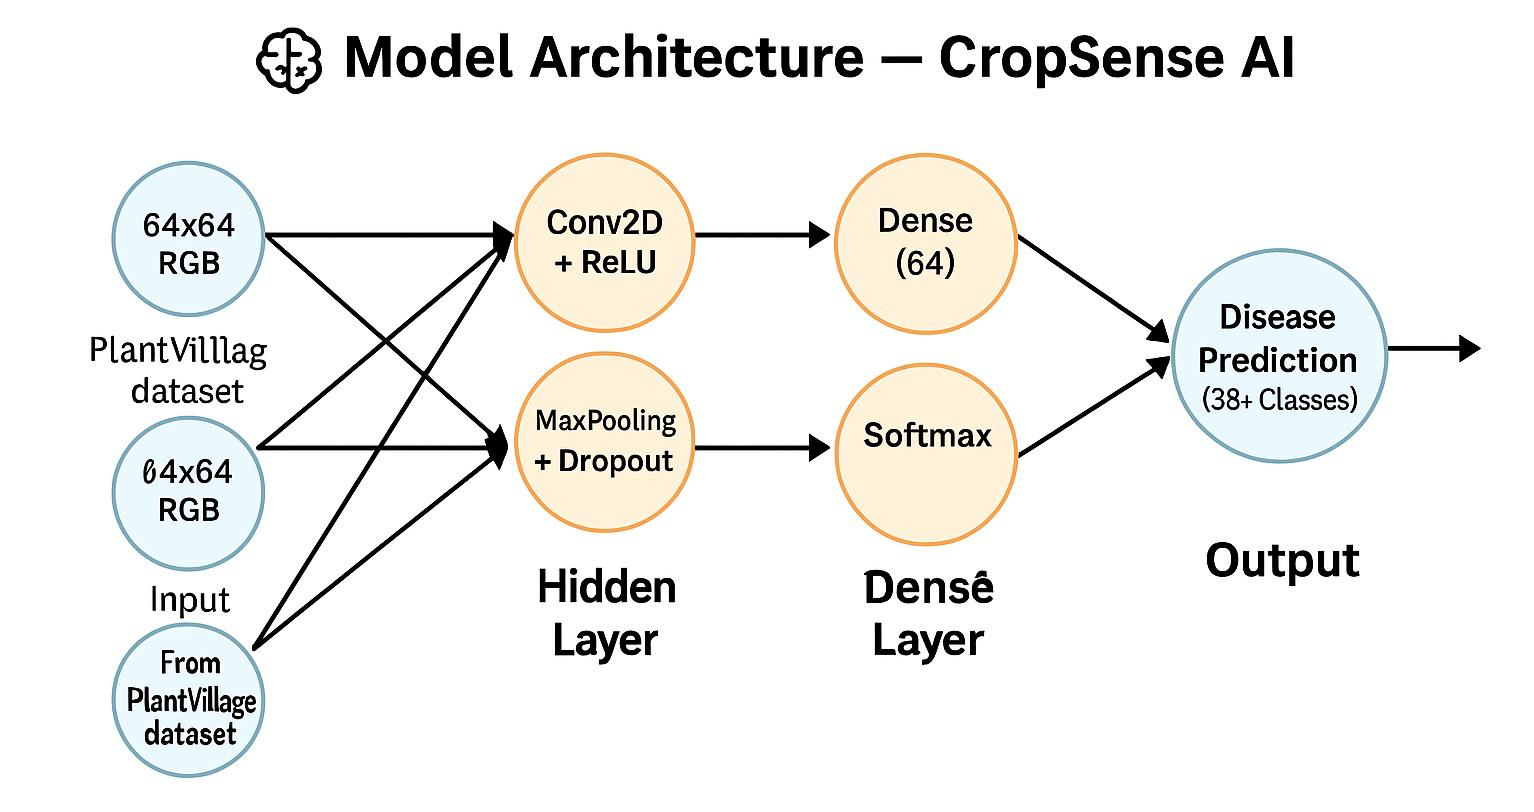

In [26]:
from IPython.display import Image, display
display(Image("model_architecture.png", width=400))

Step 3: Load PlantVillage Dataset



In [27]:
# Load PlantVillage from TFDS
(ds_train, ds_val), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# Resize, normalize, and batch
IMG_SIZE = 64
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(1)

# Check class names
class_names = ds_info.features['label'].names
print("Detected classes:", class_names)
NUM_CLASSES = len(class_names)

Detected classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_

Step 4: Define define_model() Function

In [ ]:
def define_model(optimizer='adam', regularizer=None, early_stopping=False, dropout_rate=0.3, lr=0.001, layers_num=2):
    model = models.Sequential()
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

    for _ in range(layers_num):
        model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    opt = tf.keras.optimizers.get(optimizer)
    opt.learning_rate = lr

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))

    return model, callbacks

Instance 1: Baseline Model (No Optimization)

In [ ]:
# Instance 1: Baseline model (no optimizer tuning, no early stopping, default settings)

model_1, callbacks_1 = define_model(
    optimizer='adam',          # default
    regularizer=None,          # no regularizer
    early_stopping=False,      # no early stopping
    dropout_rate=0.0,          # no dropout
    lr=0.001,                  # default learning rate
    layers_num=2               # 2 conv layers
)

history_1 = model_1.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_1,
    verbose=1
)

# Save model
os.makedirs("saved_models", exist_ok=True)
model_1.save("saved_models/model_instance_1.keras")


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 339s 246ms/step - accuracy: 0.4769 - loss: 1.9677 - val_accuracy: 0.7826 - val_loss: 0.7197
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 272s 200ms/step - accuracy: 0.8013 - loss: 0.6572 - val_accuracy: 0.8171 - val_loss: 0.5986
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 323s 201ms/step - accuracy: 0.8550 - loss: 0.4692 - val_accuracy: 0.8714 - val_loss: 0.4012
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 349s 221ms/step - accuracy: 0.8866 - loss: 0.3528 - val_accuracy: 0.8709 - val_loss: 0.3980
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 318s 233ms/step - accuracy: 0.9065 - loss: 0.2887 - val_accuracy: 0.8802 - val_loss: 0.3805
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 329s 242ms/step - accuracy: 0.9187 - loss: 0.2451 - val_accuracy: 0.8856 - val_loss: 0.3769
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 263s 193ms/step - accuracy: 0.9346 - loss: 0.1991 - val_accuracy: 0.8932 - val_loss: 0.3589
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 301s 178ms/step - ac

Evaluate & Visualize

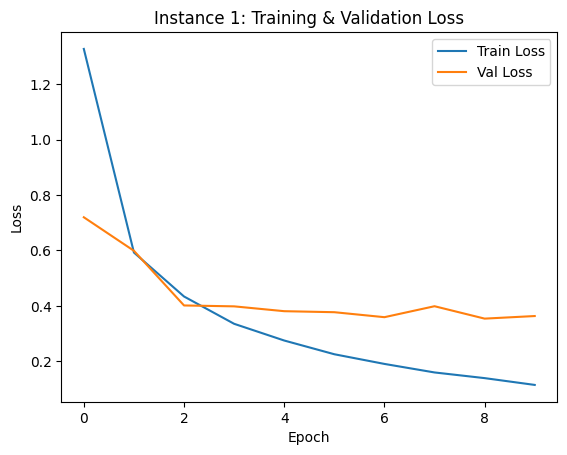

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


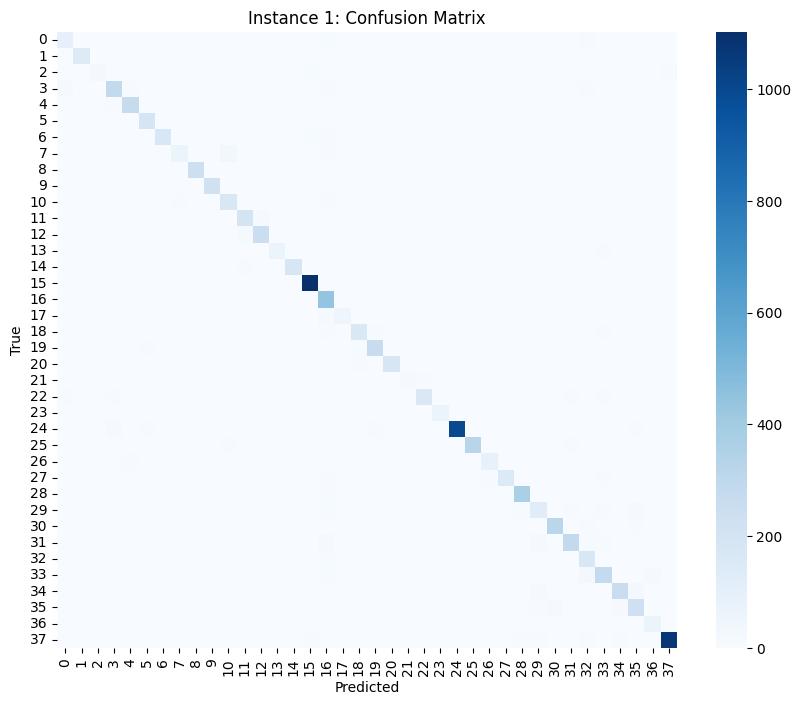

In [ ]:
# Plot loss curve
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Val Loss')
plt.title("Instance 1: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate model on validation set
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_1.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 1 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Instance 1: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Instance 2: RMSprop + L2 Regularization + Dropout + Early Stopping

In [ ]:
l2_reg = regularizers.l2(0.01)

model_2, callbacks_2 = define_model(
    optimizer='rmsprop',
    regularizer=l2_reg,
    early_stopping=True,
    dropout_rate=0.3,
    lr=0.0005,
    layers_num=3
)

history_2 = model_2.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_2,
    verbose=1
)

# Save model
model_2.save("saved_models/model_instance_2.keras")

Epoch 1/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 278s 203ms/step - accuracy: 0.2729 - loss: 3.0475 - val_accuracy: 0.5806 - val_loss: 1.6956
Epoch 2/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 344s 220ms/step - accuracy: 0.5650 - loss: 1.6957 - val_accuracy: 0.6371 - val_loss: 1.4196
Epoch 3/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 266s 196ms/step - accuracy: 0.6573 - loss: 1.3332 - val_accuracy: 0.7161 - val_loss: 1.1171
Epoch 4/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 264s 194ms/step - accuracy: 0.7050 - loss: 1.1436 - val_accuracy: 0.7665 - val_loss: 0.9402
Epoch 5/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 269s 198ms/step - accuracy: 0.7365 - loss: 1.0335 - val_accuracy: 0.7195 - val_loss: 1.0847
Epoch 6/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 267s 196ms/step - accuracy: 0.7604 - loss: 0.9463 - val_accuracy: 0.7895 - val_loss: 0.8514
Epoch 7/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 338s 208ms/step - accuracy: 0.7771 - loss: 0.8854 - val_accuracy: 0.8178 - val_loss: 0.7663
Epoch 8/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 301s 193ms/step - ac

Evaluation Cell

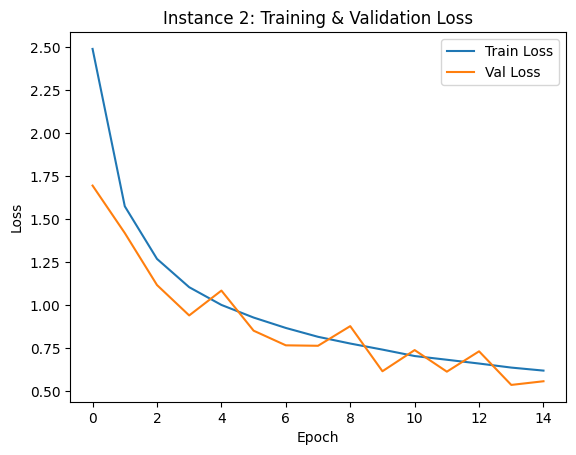

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/

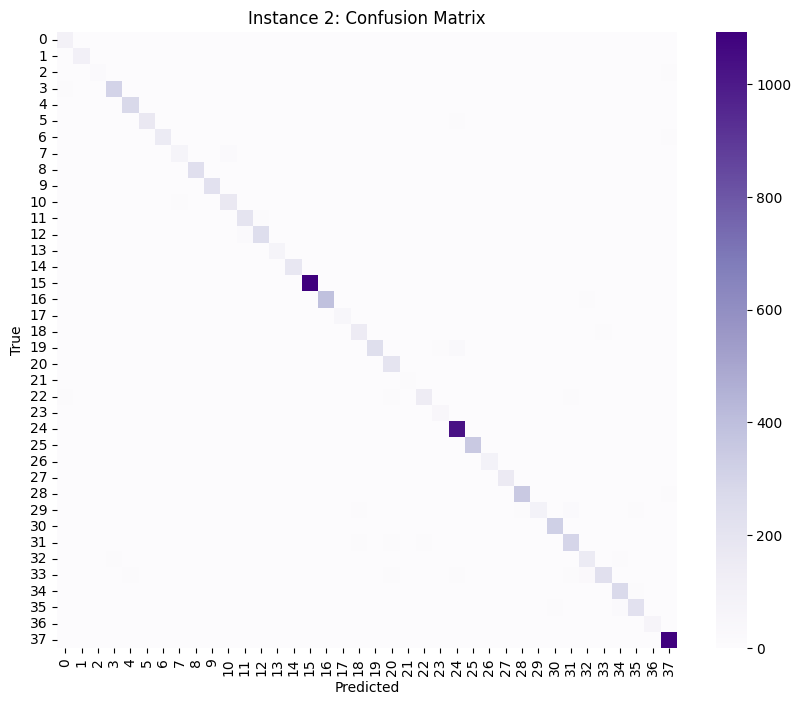

In [ ]:
# Plot loss curve
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.title("Instance 2: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_2.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 2 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Purples')
plt.title("Instance 2: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Instance 3: Adam + L1 Regularization + Dropout + More Layers

In [19]:
l1_reg = regularizers.l1(0.01)

model_3, callbacks_3 = define_model(
    optimizer='adam',
    regularizer=l1_reg,
    early_stopping=True,
    dropout_rate=0.4,
    lr=0.0003,
    layers_num=4
)

history_3 = model_3.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,  # Reduced from 15 to 10
    callbacks=callbacks_3,
    verbose=1
)

model_3.save("saved_models/model_instance_3.keras")

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 333s 224ms/step - accuracy: 0.0869 - loss: 7.8353 - val_accuracy: 0.1020 - val_loss: 3.3581
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 284s 209ms/step - accuracy: 0.1007 - loss: 3.3670 - val_accuracy: 0.1020 - val_loss: 3.3503
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 303s 222ms/step - accuracy: 0.0996 - loss: 3.3635 - val_accuracy: 0.1020 - val_loss: 3.3500
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 302s 222ms/step - accuracy: 0.1004 - loss: 3.3618 - val_accuracy: 0.1020 - val_loss: 3.3502
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 280s 206ms/step - accuracy: 0.0991 - loss: 3.3612 - val_accuracy: 0.1020 - val_loss: 3.3506
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 281s 207ms/step - accuracy: 0.0997 - loss: 3.3624 - val_accuracy: 0.1020 - val_loss: 3.3508


 Evaluation Cell

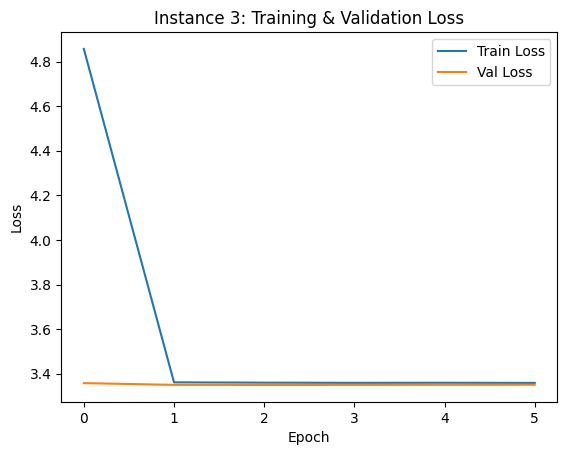

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/s

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Instance 3 Metrics:
Accuracy: 0.1020
Precision: 0.0027
Recall: 0.0263
F1-score: 0.0049


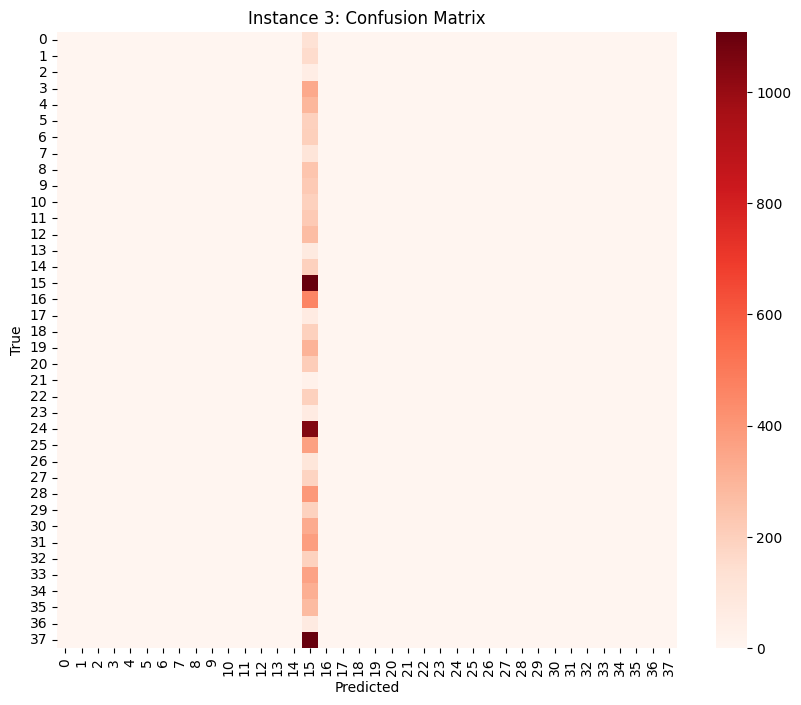

In [32]:
# Plot loss curve
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Val Loss')
plt.title("Instance 3: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_3.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 3 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Reds')
plt.title("Instance 3: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Instance 4: RMSprop + L1_L2 Combo + NO EarlyStopping

In [22]:
l1_l2_reg = regularizers.l1_l2(l1=0.005, l2=0.005)

model_4, callbacks_4 = define_model(
    optimizer='rmsprop',
    regularizer=l1_l2_reg,
    early_stopping=False,         # No EarlyStopping
    dropout_rate=0.2,
    lr=0.0007,
    layers_num=3
)

history_4 = model_4.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_4,
    verbose=1
)

model_4.save("saved_models/model_instance_4.keras")

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 304s 222ms/step - accuracy: 0.1800 - loss: 4.0876 - val_accuracy: 0.3931 - val_loss: 2.3667
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 298s 219ms/step - accuracy: 0.4447 - loss: 2.1883 - val_accuracy: 0.5546 - val_loss: 1.8520
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 280s 206ms/step - accuracy: 0.5245 - loss: 1.8683 - val_accuracy: 0.6086 - val_loss: 1.6235
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 281s 206ms/step - accuracy: 0.5743 - loss: 1.6779 - val_accuracy: 0.6418 - val_loss: 1.5093
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 275s 202ms/step - accuracy: 0.6101 - loss: 1.5515 - val_accuracy: 0.6343 - val_loss: 1.4939
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 273s 201ms/step - accuracy: 0.6346 - loss: 1.4506 - val_accuracy: 0.5766 - val_loss: 1.6201
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 272s 200ms/step - accuracy: 0.6499 - loss: 1.3835 - val_accuracy: 0.5903 - val_loss: 1.5664
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 294s 216ms/step - ac

Evaluation Cell

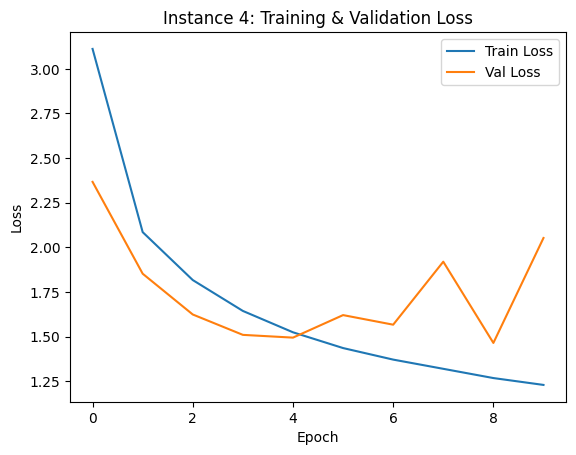

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/s

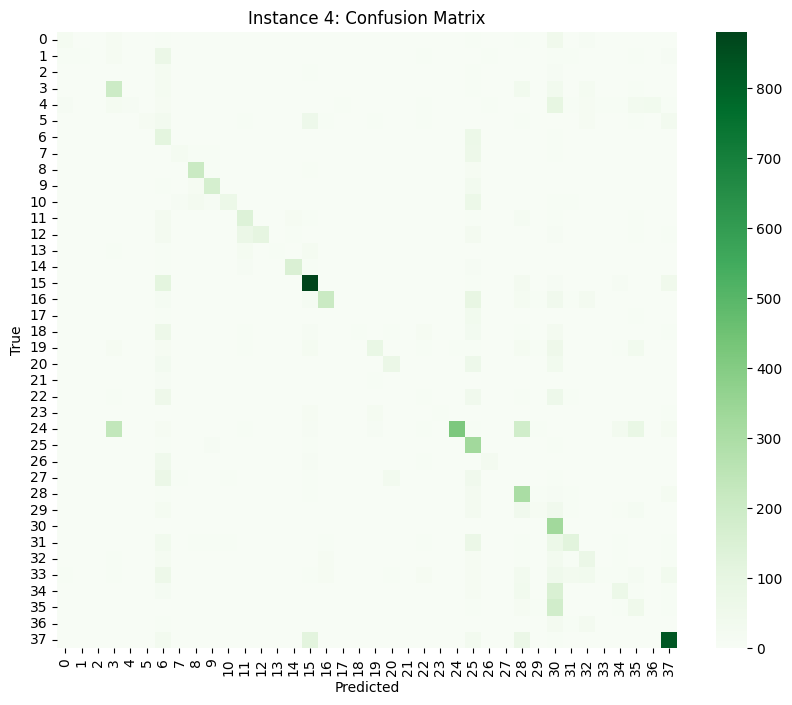

In [23]:
# Plot loss curve
plt.plot(history_4.history['loss'], label='Train Loss')
plt.plot(history_4.history['val_loss'], label='Val Loss')
plt.title("Instance 4: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_4.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 4 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Greens')
plt.title("Instance 4: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Instance 5: Adam + No Regularization + High Dropout + Tiny LR


In [24]:
model_5, callbacks_5 = define_model(
    optimizer='adam',
    regularizer=None,
    early_stopping=True,
    dropout_rate=0.5,
    lr=0.0001,
    layers_num=3
)

history_5 = model_5.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_5,
    verbose=1
)

model_5.save("saved_models/model_instance_5.keras")

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 303s 221ms/step - accuracy: 0.1317 - loss: 3.3867 - val_accuracy: 0.2923 - val_loss: 2.8646
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 282s 207ms/step - accuracy: 0.3035 - loss: 2.6006 - val_accuracy: 0.4456 - val_loss: 2.2095
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 322s 207ms/step - accuracy: 0.4240 - loss: 2.0825 - val_accuracy: 0.5620 - val_loss: 1.7944
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 267s 196ms/step - accuracy: 0.5067 - loss: 1.7458 - val_accuracy: 0.6345 - val_loss: 1.4740
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 261s 192ms/step - accuracy: 0.5657 - loss: 1.5057 - val_accuracy: 0.6703 - val_loss: 1.2990
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 299s 219ms/step - accuracy: 0.6055 - loss: 1.3477 - val_accuracy: 0.6979 - val_loss: 1.1638
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 261s 192ms/step - accuracy: 0.6379 - loss: 1.2191 - val_accuracy: 0.7227 - val_loss: 1.0502
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 262s 192ms/step - ac

Evaluation Cell

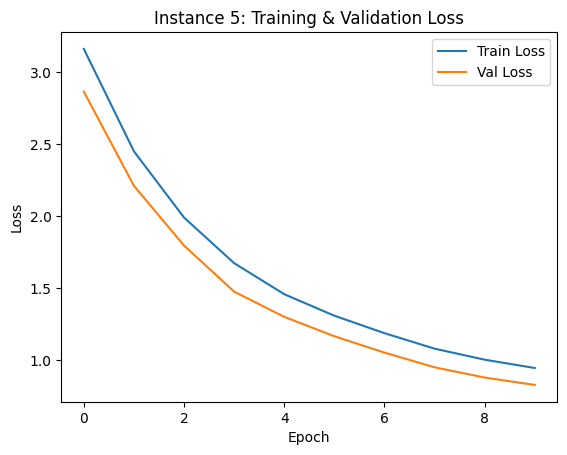

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/ste

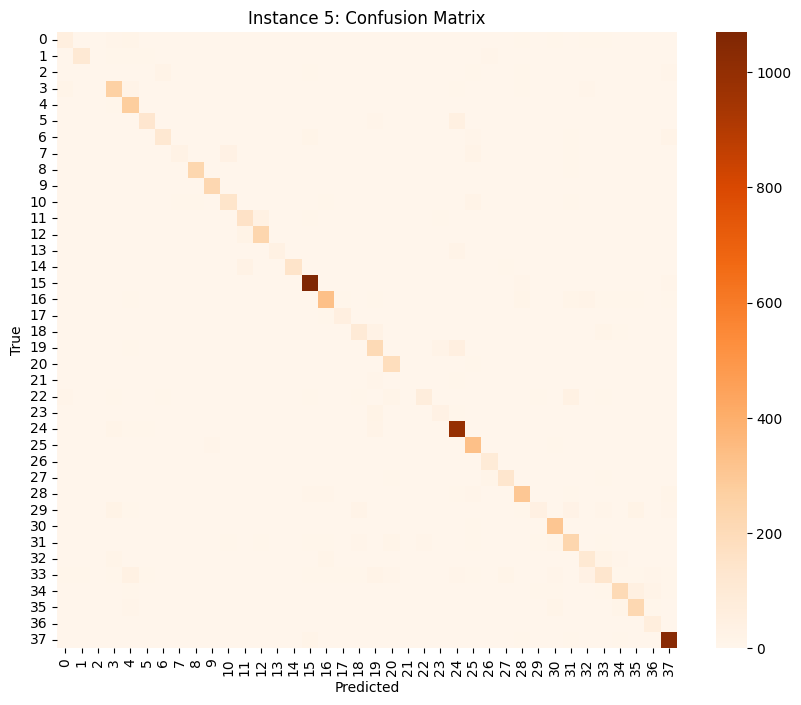

In [25]:
# Plot loss curve
plt.plot(history_5.history['loss'], label='Train Loss')
plt.plot(history_5.history['val_loss'], label='Val Loss')
plt.title("Instance 5: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_5.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 5 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Oranges')
plt.title("Instance 5: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()